### Information

The results presented here should be interpreted with caution, as the dataset used is synthetic, leading to near-perfect model performance. Chat GPT was used in some parts of the notebook, but this was explicitly mentioned in the relevant sections. In addition, the documentation was further optimised with the help of AI.

### Importing Libraries
This part imports all essential libraries for data analysis, visualization, preprocessing, and model training. Pandas and NumPy are used for data manipulation, Matplotlib and Seaborn for visualization, Scikit-learn for data preprocessing and evaluation, and TensorFlow with Keras for building and training neural networks.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import tkinter as tk
from tkinter import messagebox

import keras
from keras import layers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import country_converter as coco


### Loading the Dataset
The dataset is loaded from a CSV file named counterfeit_transaction.csv using pandas. 

In [114]:
df = pd.read_csv("counterfeit_transactions.csv")

In [115]:
df.head()

,transaction_id,customer_id,transaction_date,customer_age,customer_location,quantity,unit_price,total_amount,payment_method,shipping_speed,customer_history_orders,discount_applied,discount_percentage,shipping_cost,delivery_time_days,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit
0,TXN_957334,CUST_11907,2024-10-12 03:52:13,22,JP,1,199.66,199.66,Debit Card,Express,17,False,0.0,5.39,26,False,False,False,False,False
1,TXN_246397,CUST_27641,2024-08-18 00:36:57,62,DE,4,116.01,464.03,PayPal,Express,36,False,0.0,8.18,25,False,False,False,False,False
2,TXN_403072,CUST_78628,2024-08-19 22:21:30,75,DE,1,42.04,42.04,Credit Card,Priority,21,False,0.0,8.61,27,False,False,False,False,False
3,TXN_848560,CUST_98579,2025-04-16 18:49:39,56,BR,3,147.69,443.08,Credit Card,Standard,14,True,48.7,17.00,26,False,False,False,False,False
4,TXN_270817,CUST_67519,2024-10-06 13:30:52,19,IN,4,40.70,162.80,PayPal,Priority,48,False,0.0,20.53,1,False,False,True,False,False


### Feature selection and cleanup

Before model training, unnecessary identifier columns such as transaction_id and customer_id were removed from the dataset.

In [116]:
df = df.drop(columns=["transaction_id", "customer_id"])

### Quarter features

The transaction_date column was converted to datetime, and four binary columns (Quarter_1–Quarter_4) were created to indicate the transaction quarter. The original date column was then dropped.

In [117]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["Quarter_1"] = (df["transaction_date"].dt.quarter == 1).astype(int)
df["Quarter_2"] = (df["transaction_date"].dt.quarter == 2).astype(int)
df["Quarter_3"] = (df["transaction_date"].dt.quarter == 3).astype(int)
df["Quarter_4"] = (df["transaction_date"].dt.quarter == 4).astype(int)
df = df.drop(columns=["transaction_date"])


### Geographic features

The customer_location column was mapped to continents using the country_converter library. Binary columns were then created for each continent (e.g., Europe, Asia, South America). Afterward, the original location columns were removed. The Africa column was later dropped because it contained no relevant or non-zero entries in the dataset, meaning it provided no useful information for model training.

In [118]:
df["Continent"] = coco.convert(names=df["customer_location"], to="continent")

south_america = {"AR","BO","BR","CL","CO","EC","GY","PY","PE","SR","UY","VE"}

df["South America"] = ((df["Continent"] == "America") & (df["customer_location"].isin(south_america))).astype(int)
df["North America"] = ((df["Continent"] == "America") & (~df["customer_location"].isin(south_america))).astype(int)
df["Europe"] = (df["Continent"] == "Europe").astype(int)
df["Asia"] = (df["Continent"] == "Asia").astype(int)
df["Africa"] = (df["Continent"] == "Africa").astype(int)
df["Oceania"] = (df["Continent"] == "Oceania").astype(int)

df = df.drop(columns=["customer_location", "Continent", "Africa"])


### Payment features

The two most frequent payment methods were identified and converted into binary columns. An additional column marked all other methods. The original payment_method column was then dropped.

In [119]:
top2_payment = df["payment_method"].value_counts().nlargest(2).index

df["payment_" + top2_payment[0].replace(" ", "_")] = (df["payment_method"] == top2_payment[0]).astype(int)
df["payment_" + top2_payment[1].replace(" ", "_")] = (df["payment_method"] == top2_payment[1]).astype(int)
df["other_payment_method"] = (~df["payment_method"].isin(top2_payment)).astype(int)

df = df.drop(columns=["payment_method"])


### Shipping features

The two most common shipping speeds were encoded as binary columns, with an additional column for all other options. The original shipping_speed column was removed.

In [120]:
top2_shipping = df["shipping_speed"].value_counts().nlargest(2).index

df["shipping_" + top2_shipping[0].replace(" ", "_")] = (df["shipping_speed"] == top2_shipping[0]).astype(int)
df["shipping_" + top2_shipping[1].replace(" ", "_")] = (df["shipping_speed"] == top2_shipping[1]).astype(int)
df["other_shipping_speed"] = (~df["shipping_speed"].isin(top2_shipping)).astype(int)

df = df.drop(columns=["shipping_speed"])


### Boolean conversion

Selected boolean columns were converted to integer format (0/1) to ensure consistency for model training.

In [121]:
bool_cols = [
    "Europe", "North America", "Oceania", "South America",
    "discount_applied","refund_requested","velocity_flag",
    "geolocation_mismatch","device_fingerprint_new","involves_counterfeit"
]
df[bool_cols] = df[bool_cols].astype(int)

### Missing Values Check

All numerical columns, except involves_counterfeit, are selected to check for missing values. The code prints the number of missing entries per column and the total number of missing values across the dataset, helping identify data completeness issues before model training.

In [122]:
num_cols = df.select_dtypes(include=[np.number]).columns.difference(["involves_counterfeit"])

missing_per_column = df[num_cols].isna().sum()
print(missing_per_column)

print("\nTotal missing values:", missing_per_column.sum())


Asia                       0
Europe                     0
North America              0
Oceania                    0
Quarter_1                  0
Quarter_2                  0
Quarter_3                  0
Quarter_4                  0
South America              0
customer_age               0
customer_history_orders    0
delivery_time_days         0
device_fingerprint_new     0
discount_applied           0
discount_percentage        0
geolocation_mismatch       0
other_payment_method       0
other_shipping_speed       0
payment_Credit_Card        0
payment_PayPal             0
quantity                   0
refund_requested           0
shipping_Express           0
shipping_Standard          0
shipping_cost              0
total_amount               0
unit_price                 0
velocity_flag              0
dtype: int64

Total missing values: 0


### Duplicate Check and Removal

The datast is checked for duplicat rows to ensure data integrity. Any duplicated founrd are displayed, then removed, and the index is reset. Thes step prevents redundant records from biasing the model or affecting statistical analysis.

In [123]:
duplicates_count = df.duplicated().sum()
print("Number of duplicates:", duplicates_count)

if duplicates_count > 0:
    display(df[df.duplicated()])

df = df.drop_duplicates().reset_index(drop=True)
print("After dropping duplicates:", df.duplicated().sum())


Number of duplicates: 0
After dropping duplicates: 0


### Feature and target split

The dataset was divided into features (X) and the target variable (y), where involves_counterfeit serves as the classification label.

In [124]:
X = df.drop(columns=["involves_counterfeit"])
y = df["involves_counterfeit"].astype(int)

print("Features:", X.shape, "Target:", y.shape)


Features: (3000, 28) Target: (3000,)


### Correlation analysis

A correlation matrix was computed to identify relationships between features and the target variable involves_counterfeit. The strongest positive correlations were found with quantity and refund_requested, while customer_history_orders and unit_price showed the strongest negative correlations.

In [125]:
corr_matrix = df.corr()['involves_counterfeit']
corr_matrix.sort_values(ascending=False)

involves_counterfeit       1.000000
quantity                   0.764782
refund_requested           0.349443
other_shipping_speed       0.206741
total_amount               0.186583
shipping_Standard          0.107036
payment_Credit_Card        0.021951
shipping_cost              0.019346
geolocation_mismatch       0.013693
Quarter_2                  0.013424
Europe                     0.011625
Oceania                    0.009564
other_payment_method       0.009426
Quarter_3                  0.006690
device_fingerprint_new     0.005886
customer_age               0.005421
Asia                      -0.002109
Quarter_4                 -0.004853
South America             -0.005854
velocity_flag             -0.006705
discount_applied          -0.010856
North America             -0.012090
delivery_time_days        -0.012864
Quarter_1                 -0.015211
discount_percentage       -0.018855
payment_PayPal            -0.032631
shipping_Express          -0.342310
unit_price                -0

### Feature importance (Chi^2 test)

A Chi^2 feature selection test was applied to evaluate the relationship between each input feature and the target variable. The highest scores were observed for unit_price, total_amount, and customer_history_orders, indicating strong relevance to counterfeit detection.

In [126]:
X_cat = X.copy()

X_cat = X_cat.apply(lambda col: col.clip(lower=0))

chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(X_cat, y)

scores = pd.DataFrame({
    "Feature": X_cat.columns,
    "Score": chi2_selector.scores_
}).sort_values(by="Score", ascending=False)

print(scores)


                    Feature         Score
2                unit_price  47665.712697
3              total_amount  26536.930924
4   customer_history_orders  15197.743129
1                  quantity   7738.265963
9          refund_requested    300.390818
26         shipping_Express    258.021173
27     other_shipping_speed     81.081171
6       discount_percentage     26.836213
25        shipping_Standard     21.779147
7             shipping_cost      2.416274
22           payment_PayPal      2.373400
8        delivery_time_days      2.283790
23      payment_Credit_Card      1.079330
0              customer_age      0.580262
13                Quarter_1      0.520362
11     geolocation_mismatch      0.471573
14                Quarter_2      0.405992
18            North America      0.306821
19                   Europe      0.283142
21                  Oceania      0.248077
5          discount_applied      0.243853
24     other_payment_method      0.136039
10            velocity_flag      0

In [127]:
y_encoded = to_categorical(y)

print("Example:", y[:5].tolist(), "→", y_encoded[:5])


Example: [0, 0, 0, 0, 0] → [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [128]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.35, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)


Train: (1950, 28) Validation: (525, 28) Test: (525, 28)


### Model architecture

A neural network was built using Keras. It includes batch normalization, three hidden layers (64, 32, and 18 neurons) with ReLU activation, and dropout regularization to prevent overfitting. The output layer uses a softmax activation for binary classification.

In [129]:
variable_amount = X_train.shape[1]

mc = ModelCheckpoint("best_model_counterfeit.keras", monitor="val_loss", mode="min", save_best_only=True)
es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6, verbose=1)
callbacks_opt = [mc, es, rlr]

model = keras.Sequential([
    layers.BatchNormalization(input_shape=(variable_amount,)),
    layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.1)),
    layers.Dropout(0.1),
    layers.Dense(32, activation="relu"),
    layers.Dense(18, activation="relu"),
    layers.Dense(2, activation="softmax")  
])

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


model.summary()


c:\Users\Mani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 28)             │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 18)             │           594 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            38 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,680 (18.28 KB)

 Trainable params: 4,624 (18.06 KB)

 Non-trainable params: 56 (224.00 B)

### Model training

The model was trained for up to 2000 epochs, but training stopped early after 198 epochs due to the Early Stopping callback, which detected no further improvement in validation performance.

In [130]:
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=2000,callbacks=callbacks_opt, verbose=1)

Epoch 1/2000
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7190 - loss: 18.3103 - val_accuracy: 0.7676 - val_loss: 13.5574 - learning_rate: 0.0010
Epoch 2/2000
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8744 - loss: 9.8861 - val_accuracy: 0.9600 - val_loss: 6.4374 - learning_rate: 0.0010
Epoch 3/2000
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9431 - loss: 4.0753 - val_accuracy: 0.9410 - val_loss: 2.0339 - learning_rate: 0.0010
Epoch 4/2000
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9508 - loss: 1.0011 - val_accuracy: 0.9714 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 5/2000
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9503 - loss: 0.2969 - val_accuracy: 0.9714 - val_loss: 0.2444 - learning_rate: 0.0010
Epoch 6/2000
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9523 - loss: 0.2623 - val_accuracy: 0.9657 - val_loss: 0.2137 - learning_rate: 0.0010
Epoch 7/2000
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9497 - loss: 0.25

### Training performance

The loss and validation loss both decreased rapidly during the initial epochs and stabilized near zero, indicating that the model converged quickly. The close alignment between training and validation curves suggests consistent generalization without overfitting.

<Axes: >

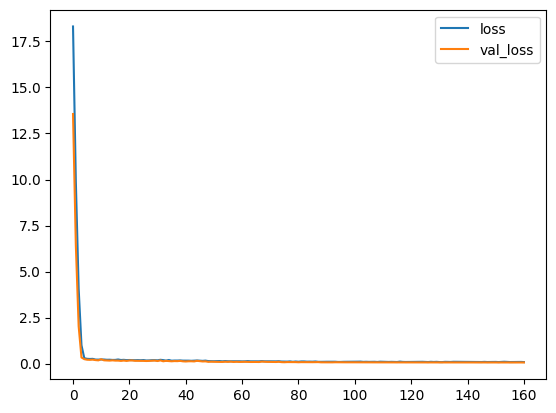

In [131]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

### Accuracy performance

Both training and validation accuracy increased rapidly during the early epochs and remained high afterward. The validation accuracy reached nearly 100%, indicating strong predictive performance and stable generalization across the dataset.

<Axes: >

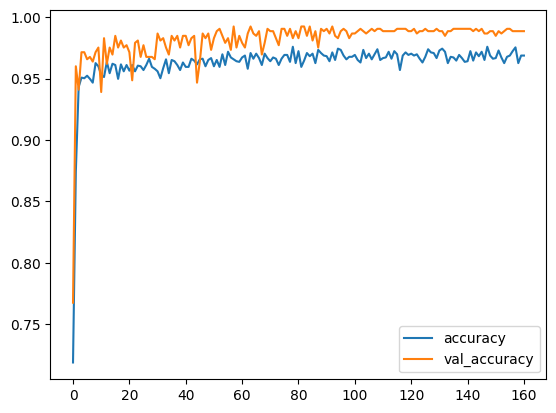

In [132]:
loss_df[['accuracy', 'val_accuracy']].plot()


### Model evaluation

The model achieved an accuracy of 98.29% on the test data and 97.74% on the training data, showing consistent performance and good generalization with minimal overfitting.

In [133]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:


[0.06997565180063248, 0.9847618937492371]

Train data evaluation:
[0.07305649667978287, 0.9779487252235413]


In [134]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [135]:
categories = ["no counterfeit", "counterfeit"]


### Confusion matrix

The confusion matrix shows that the model correctly classified 390 non-counterfeit and 126 counterfeit cases. Only 9 misclassifications occurred in total, indicating high precision and recall in detecting counterfeit transactions.

<Axes: >

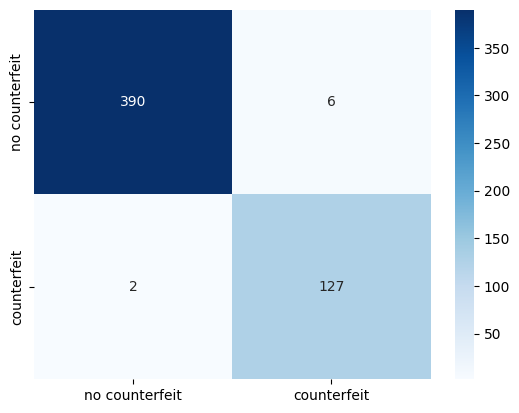

In [136]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories, cmap="Blues")


### Classification report

The model achieved an overall accuracy of 98.29%. Precision, recall, and F1-scores were all above 0.95 for both classes, showing strong and balanced performance in detecting counterfeit and non-counterfeit transactions.

In [137]:
print(classification_report(y_test, test_predictions, target_names=categories))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

                precision    recall  f1-score   support

no counterfeit       0.99      0.98      0.99       396
   counterfeit       0.95      0.98      0.97       129

      accuracy                           0.98       525
     macro avg       0.97      0.98      0.98       525
  weighted avg       0.99      0.98      0.98       525


Model overall accuracy: 98.48%


### ROC-AUC score

The model achieved a ROC-AUC score of 0.999, indicating an excellent ability to distinguish between counterfeit and non-counterfeit transactions.

In [138]:
y_pred_proba = model.predict(X_test)

y_pred_proba = y_pred_proba[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score: {:.3f}".format(auc))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
ROC-AUC Score: 0.998


### Logistic Regression 
The Logistic Regression implementation used in this project is based on following source: https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/linear_model/_logistic.py. GPT was used to assist in optimizing and simplifying the code structure. The outcomes generated with GPT-guided optimization were validated through reproducible scikit-learn methods, which confirms that the reported accuracy and ROC-AUC values are reliable and based on standard, verifiable computations.

In [149]:
y_train, y_test = map(lambda y: np.argmax(y, axis=1) if y.ndim > 1 else y, [y_train, y_test])

scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)


In [150]:
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)

test_pred = log_reg.predict(X_test)
test_probs = log_reg.predict_proba(X_test)[:, 1] 

In [151]:
acc = accuracy_score(y_test, test_pred)
roc_auc = roc_auc_score(y_test, test_probs)

Model Overall Accuracy: 0.9733
ROC-AUC: 0.9980

                precision    recall  f1-score   support

No Counterfeit       0.98      0.98      0.98       396
   Counterfeit       0.95      0.94      0.95       129

      accuracy                           0.97       525
     macro avg       0.97      0.96      0.96       525
  weighted avg       0.97      0.97      0.97       525



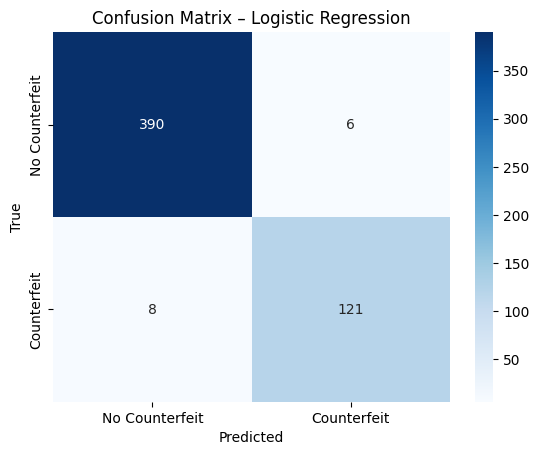

In [153]:
print(f"Model Overall Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}\n")
print(classification_report(y_test, test_pred, target_names=['No Counterfeit', 'Counterfeit']))

sns.heatmap(
    confusion_matrix(y_test, test_pred),
    annot=True, fmt='g', cmap='Blues',
    xticklabels=['No Counterfeit', 'Counterfeit'],
    yticklabels=['No Counterfeit', 'Counterfeit']
)
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

### Model Comparison: Neural Network vs. Logistic Regression

The Neural Network model achieved an overall accuracy of 98.48% and a ROC-AUC score of 0.998, demonstrating excellent capability in capturing complex, non-linear relationships within the data.

The Logistic Regression model reached a slightly lower accuracy of 97.33% and a ROC-AUC score of 0.998. Despite its simpler linear structure, it performed nearly as well as the neural network, indicating that the dataset is highly separable and the underlying patterns are mostly linear.

Overall, both models produced almost identical results.

In [ ]:
X.columns

Index(['customer_age', 'quantity', 'unit_price', 'total_amount',
       'customer_history_orders', 'discount_applied', 'discount_percentage',
       'shipping_cost', 'delivery_time_days', 'refund_requested',
       'velocity_flag', 'geolocation_mismatch', 'device_fingerprint_new',
       'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'South America',
       'North America', 'Europe', 'Asia', 'Oceania', 'payment_PayPal',
       'payment_Credit_Card', 'other_payment_method', 'shipping_Standard',
       'shipping_Express', 'other_shipping_speed'],
      dtype='object')

In [ ]:
tester_row = {
    "quantity": 2,
    "total_amount": 150.0,
    "shipping_cost": 10.0,
    "delivery_time_days": 3,
    "discount_percentage": 5.0,
    "customer_age": 34,
    "customer_history_orders": 10,
    "unit_price": 50.0,
    "refund_requested": 0,
    "velocity_flag": 0,
    "geolocation_mismatch": 0,
    "device_fingerprint_new": 0,
    "discount_applied": 1,
    "Quarter_1": 0,
    "Quarter_2": 1,
    "Quarter_3": 0,
    "Quarter_4": 0,
    "North America": 1,
    "South America": 0,
    "Europe": 0,
    "Asia": 0,
    "Oceania": 0,
    "payment_Credit_Card": 1,
    "payment_PayPal": 0,
    "other_payment_method": 0,
    "shipping_Standard": 1,
    "shipping_Express": 0,
    "other_shipping_speed": 0
}

tester_row = pd.DataFrame([tester_row])
tester_row = tester_row.reindex(columns=X.columns, fill_value=0)

prob = model.predict(tester_row)[0][0]

threshold = 0.5
prediction = "Counterfeit" if prob >= threshold else "No Counterfeit"

print(f"Predicted class: {prediction}")
print(f"Probability for Counterfeit: {prob:.4f}")
print(f"Probability for No Counterfeit: {1 - prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted class: Counterfeit
Probability for Counterfeit: 0.8728
Probability for No Counterfeit: 0.1272


### Counterfeit Transaction Prediction GUI

For demonstration purposes, a simple GUI was implemented using Tkinter. The interface allows the user to input feature values (with default examples provided) and receive a predicted counterfeit expectancy directly from the trained model.

This GUI code was generated entirely by GPT, since I had never used Tkinter before and wanted a quick and simple way to build an interface for testing predictions. The correctness was ensured by checking that all model input features are represented in the GUI and that the prediction output matches the expected format.

In [ ]:

model = load_model("best_model_counterfeit.keras")

default_values = {
    "quantity": 2,
    "total_amount": 150.0,
    "shipping_cost": 10.0,
    "delivery_time_days": 3,
    "discount_percentage": 5.0,
    "customer_age": 34,
    "customer_history_orders": 10,
    "unit_price": 50.0,
    "refund_requested": 0,
    "velocity_flag": 0,
    "geolocation_mismatch": 0,
    "device_fingerprint_new": 0,
    "discount_applied": 1,
    "Quarter_1": 0,
    "Quarter_2": 1,
    "Quarter_3": 0,
    "Quarter_4": 0,
    "North America": 1,
    "South America": 0,
    "Europe": 0,
    "Asia": 0,
    "Oceania": 0,
    "payment_Credit_Card": 1,
    "payment_PayPal": 0,
    "other_payment_method": 0,
    "shipping_Standard": 1,
    "shipping_Express": 0,
    "other_shipping_speed": 0
}

entries = {}

def predict():
    try:
        data = {f: float(entries[f].get()) for f in default_values.keys()}
        df = pd.DataFrame([data])
        pred = model.predict(df, verbose=0)[0][0]
        result_label.config(text=f"Predicted Life Expectancy: {pred:.2f} years")
    except Exception as e:
        messagebox.showerror("Error", str(e))

root = tk.Tk()
root.title("Life Expectancy Predictor")

for f, example in default_values.items():
    row = tk.Frame(root)
    lab = tk.Label(row, width=25, text=f+": ", anchor="w")
    ent = tk.Entry(row)
    ent.insert(0, str(example))  
    hint = tk.Label(row, width=15, text=f"(e.g. {example})", anchor="w", fg="grey")
    
    row.pack(side=tk.TOP, fill=tk.X, padx=5, pady=2)
    lab.pack(side=tk.LEFT)
    ent.pack(side=tk.LEFT, expand=tk.YES, fill=tk.X)
    hint.pack(side=tk.RIGHT)
    
    entries[f] = ent

predict_button = tk.Button(root, text="Predict", command=predict)
predict_button.pack(pady=10)

result_label = tk.Label(root, text="Prediction will appear here", font=("Helvetica", 12))
result_label.pack(pady=10)

root.mainloop()
